In [2]:
# fazendo importações

import warnings
import pandas as pd
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.preprocessing import MinMaxScaler

In [3]:
# ignorando warnings

warnings.filterwarnings("ignore")

In [4]:
# definindo colunas e tamanho

colspecs = [(2, 10), (10, 22), (56, 69), (82, 95)]
names = ['date', 'cod', 'opening-price', 'closing-price']

# carregando arquivos e criando dataFrames

df22 = pd.read_fwf('../../bkp-CSVB3/COTAHIST_A2023.TXT', colspecs=colspecs, names=names, header=None)
df23 = pd.read_fwf('../../bkp-CSVB3/COTAHIST_A2022.TXT', colspecs=colspecs, names=names, header=None)
df24 = pd.read_fwf('../../bkp-CSVB3/COTAHIST_A2024.TXT', colspecs=colspecs, names=names, header=None)

# filtrando das ações da Ambev (ABEV3)

ABEV3_df22 = df22[df22['cod'].str.endswith('ABEV3')]
ABEV3_df23 = df23[df23['cod'].str.endswith('ABEV3')]
ABEV3_df24 = df24[df24['cod'].str.endswith('ABEV3')]

# unificando dataFrames

df = pd.concat([ABEV3_df22, ABEV3_df23, ABEV3_df24], ignore_index=True)

# lendo valores

df.head(20)
print(df)

         date      cod  opening-price  closing-price
0    20230102  02ABEV3         1440.0         1402.0
1    20230103  02ABEV3         1416.0         1411.0
2    20230104  02ABEV3         1428.0         1408.0
3    20230105  02ABEV3         1427.0         1414.0
4    20230106  02ABEV3         1430.0         1416.0
..        ...      ...            ...            ...
554  20240322  02ABEV3         1256.0         1237.0
555  20240325  02ABEV3         1240.0         1223.0
556  20240326  02ABEV3         1220.0         1217.0
557  20240327  02ABEV3         1236.0         1230.0
558  20240328  02ABEV3         1238.0         1236.0

[559 rows x 4 columns]


In [5]:
# função para converter 'date' em formato de data

df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')

In [6]:
# dividindo os dados em treinamento (2022 e 2023) e teste (2024)

train_data = df[(df['date'].dt.year == 2022) | (df['date'].dt.year == 2023)]
test_data = df[df['date'].dt.year == 2024]

In [7]:
# selecionando apenas as colunas relevantes para o ARIMA (data e closing price)

train_data = train_data[['date', 'closing-price']]
test_data = test_data[['date', 'closing-price']]

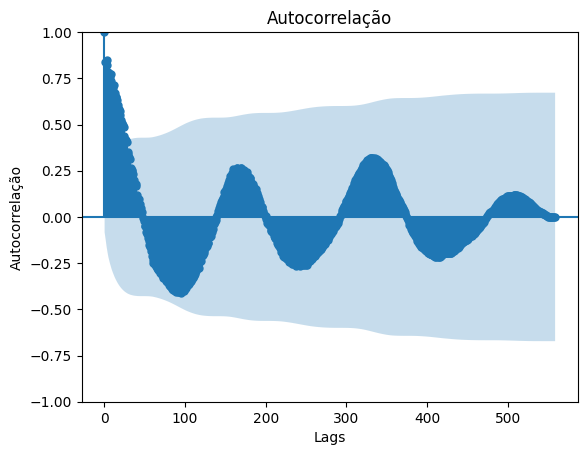

In [8]:
# definindo o valor de série para definir o valor de pdq com base na autocorrelação dos dados
series = df['closing-price']

# plotando a autocorrelação com lags até o número de pontos na série temporal
plot_acf(series, lags=len(series)-1)
plt.xlabel('Lags')
plt.ylabel('Autocorrelação')
plt.title('Autocorrelação')
plt.show()

In [16]:
# configurando do modelo ARIMA

model = ARIMA(train_data['closing-price'], order=(5,1,5)) # através dos dados de autocorrelação defini o pdq do ARIMA
model_fit = model.fit()

In [17]:
# fazendo previsões para 2024

predictions = model_fit.forecast(steps=12)

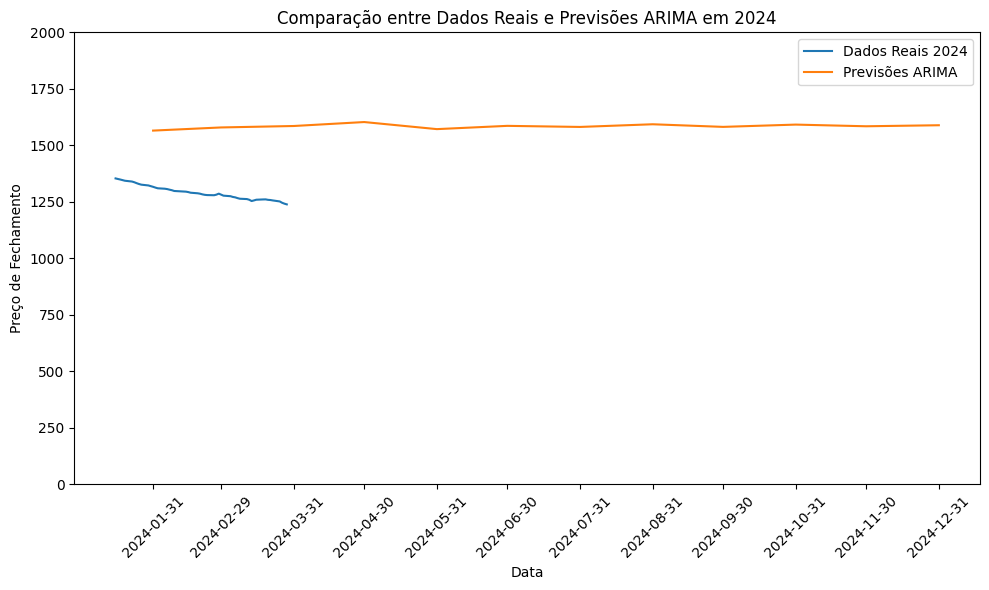

In [21]:
# suavizando dados reais para plot do gráfico

window_size = 10 # utilizei uma escala de suavização bem agressiva
test_data['smoothed'] = test_data['closing-price'].rolling(window=window_size).mean()

# criando DataFrame para as previsões

predicted_dates = pd.date_range(start='2024-01-01', periods=12, freq='M')
predicted_data = pd.DataFrame({'date': predicted_dates, 'predicted': predictions})

# plotando o gráfico

plt.figure(figsize=(10, 6))
plt.plot(test_data['date'], test_data['smoothed'], label='Dados Reais 2024')
plt.plot(predicted_data['date'], predicted_data['predicted'], label='Previsões ARIMA')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.title('Comparação entre Dados Reais e Previsões ARIMA em 2024')
plt.legend()
plt.xticks(predicted_data['date'], rotation=45)
plt.ylim(bottom=0, top=2000) # com essa escala foi possível aproximar mais o real do previsto, visualmente falando
plt.tight_layout()
plt.show()
